In [1]:
import numpy as np
from scipy.stats import gamma, cauchy, multivariate_normal, norm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def accept_reject(accept_prob):
    u = np.random.uniform(low=0.0, high=1.0, size=1)
    return u < accept_prob

In [4]:
def l_gamma_prior(l, a, b):
    return gamma.pdf(l, a=a, scale=1/b)

In [5]:
def s_half_cauchy_prior(s, scale):
    return 2 * cauchy.pdf(s, loc=0, scale=scale)

In [6]:
def kernel_covariance(x, l, s, noise=1e-3):
    t = x.shape[0]
    cov_sample = np.zeros((t, t))
    for i in range(t):
        for j in range(t):
            cov_sample[i, j] = s ** 2 * np.exp(-(x[i] - x[j]) ** 2 / (2 * l ** 2))
    cov_sample += np.eye(t) * noise
    return cov_sample

In [7]:
def gp_marginal_likelihood(y, x, l, s):
    t = y.shape[0]
    mu = np.repeat(0, t)
    cov = kernel_covariance(x, l, s)
    return multivariate_normal.pdf(y, mu, cov)

In [8]:
def propose_new(current, std):
    value = -1
    while value < 0:
        value = np.random.normal(loc=current, scale=std, size=1)
    return value

In [9]:
def calculate_p(l, s, y, x, prior_params):
    a, b, scale = prior_params
    return l_gamma_prior(l, a, b) * s_half_cauchy_prior(s, scale) * gp_marginal_likelihood(y, x, l, s)

In [13]:
def calculate_p_new(l, s, Y, x, prior_params):
    a, b, scale = prior_params
    prior = l_gamma_prior(l, a, b) #* s_half_cauchy_prior(s, scale)
    loglik = 0.0
    for j in range(Y.shape[1]):
        #print(np.log(gp_marginal_likelihood(Y[:, j], x, l, s)))
        loglik += np.log(gp_marginal_likelihood(Y[:, j], x, l, s)) # independent observations
    return np.log(prior) + loglik

In [14]:
def metropolis_update(l, s, y, x, prior_params, proposal_params):
    p_current = calculate_p(l, s, y, x, prior_params)

    l_new = propose_new(l, proposal_params[0])
    s_new = propose_new(s, proposal_params[1])

    p_new = calculate_p(l_new, s_new, y, x, prior_params)
    
    if accept_reject(p_new / p_current):
        return l_new, s_new
    else:
        return l, s

In [15]:
def metropolis_update_new(l, s, p, Y, x, prior_params, proposal_params):
    l_new = propose_new(l, proposal_params[0])
    #s_new = propose_new(s, proposal_params[1])
    s_new = 1.0
    
    p_new = calculate_p_new(l_new, s_new, Y, x, prior_params)
    
    if accept_reject(np.exp(p_new - p)):
        return l_new, s_new, p_new
    else:
        return l, s, p

In [16]:
from tqdm import tqdm as tqdm

In [17]:
def metropolis_sample(n_iter, y, x, prior_params=[10, 0.1, 0.5], proposal_params=[0.5, 0.5]):
    l = propose_new(1, proposal_params[0])
    s = propose_new(1, proposal_params[1])
    
    l_trace = []
    s_trace = []
    for i in tqdm(range(n_iter)):
        l, s = metropolis_update(l, s, y, x, prior_params, proposal_params)
        l_trace.append(l)
        s_trace.append(s)
    
    return l_trace, s_trace

In [33]:
def metropolis_sample_new(n_iter, Y, x, prior_params=[10, 0.1, 0.5], proposal_params=[0.1, 0.1]):
    l = propose_new(1, proposal_params[0])
    #s = propose_new(1, proposal_params[1])
    s = 1.0
    p = calculate_p_new(l, s, Y, x, prior_params)
    
    l_trace = []
    s_trace = []
    for i in tqdm(range(n_iter)):
        l, s, p = metropolis_update_new(l, s, p, Y, x, prior_params, proposal_params)
        l_trace.append(l)
        s_trace.append(s)
        #for j in range(10):
        #    extra = gp_marginal_likelihood(y, x, l, s)
    
    return l_trace, s_trace

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [20]:
gp = GaussianProcessRegressor(kernel=RBF())

In [21]:
x = np.linspace(0.1, 5, 50)
Y = gp.sample_y(x.reshape((50, 1)), 10) + np.random.normal(0, 0.01, [50, 10])
y = Y[:, 0]
#y = np.sin(x) + np.random.normal(0, 0.01, 50)

In [22]:
print(Y.shape)

(50, 10)


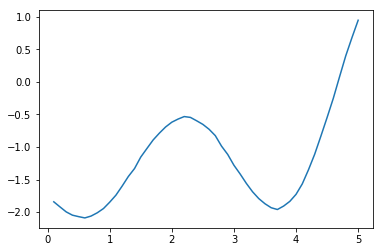

In [23]:
plt.plot(x, y)
plt.show()

In [24]:
import time

In [25]:
t0 = time.time()

for i in range(10):
    l = 1 + i * 0.01
    s = 1 + i * 0.01
    gp_marginal_likelihood(y, x, l, s)
    #gp_marginal_likelihood(y, x, l, s)
    
t1 = time.time()
print(t1 - t0)

0.0952670574188


In [34]:
t0 = time.time()

test = metropolis_sample_new(500, Y, x)

t1 = time.time()
print(t1 - t0)

100%|██████████| 500/500 [01:35<00:00,  5.32it/s]

95.6952311993


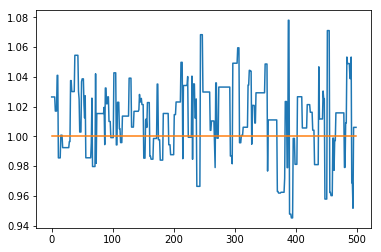

In [35]:
plt.plot(test[0])
plt.plot(test[1])
plt.show()

In [143]:
import pymc3 as pm

In [146]:
t0 = time.time()

with pm.Model() as model:
    l = pm.Gamma('l', 10, 0.1)  # informative prior for length scale
    s = pm.HalfCauchy('s', 0.5)  # recommended prior for scale parameter
    K = s ** 2 * pm.gp.cov.ExpQuad(1, l)  
    gp = pm.gp.Marginal(cov_func=K)
    y_ = gp.marginal_likelihood('y', X=x.reshape((500, 1)), y=y, noise=1e-3)
    trace = pm.sample(100, Metropolis())
    
t1 = time.time()
print(t1 - t0)

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [l]
The gelman-rubin statistic is larger than 1.2 for some parameters.
The number of effective samples is smaller than 10% for some parameters.


46.1658730507


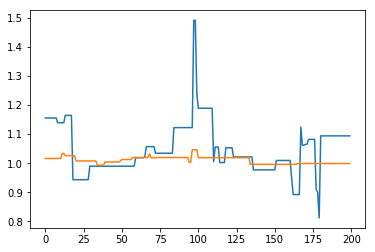

In [150]:
plt.plot(trace['s'])
plt.plot(trace['l'])
plt.show()

In [73]:
from gibbs import *

In [85]:
mu_0 = np.repeat(0, 10)  # prior mean 0 for regression coefficients
Sigma_0 = np.diag(np.repeat(1, 10))  # prior variance 1
a_0 = 1  # Inverse-Gamma(1, 1) is fairly diffused
b_0 = 1

In [86]:
F = np.random.normal(0, 1, [10000, 10])
loading = np.random.normal(0, 1, [10, 100])
Y = np.matmul(F, loading) + np.random.normal(0, 0.1, [10000, 100])

In [87]:
t0 = time.time()

loading_matrix, Y_variance = blr_mv(Y, F, mu_0, Sigma_0, a_0, b_0)

t1 = time.time()
print(t1 - t0)

0.16050195694


In [95]:
cov1 = kernel_covariance(x, 1.0, 1.0)
cov2 = kernel_covariance(x, 1.0, 1.0)
loading_matrix = np.random.normal(0, 1, [2, 20])
Y_variance = np.random.normal(0, 1, 20) ** 2
Y = np.random.normal(0, 1, [100, 20])

In [96]:
t0 = time.time()

for i in range(50):
    S1, S2, S3, S4 = build_covariance_blocks([cov1, cov2], loading_matrix, Y_variance)
    F_new, cov_new = sample_conditional_F(Y, S1, S2, S3, S4, debug=True)
    
t1 = time.time()
print(t1 - t0)

34.1250851154
